# Python / Tensorflow implementation of the kernel measure compression algorithm

In this notebook you can find a Python / Tensorflow implementation of the kernel measure compression algorithm in the paper
"Algorithms that get old : the case of generative deep neural networks" published in the LOD conference proceedings and arXiv:2202.03008 [stat.ML], direct link : https://arxiv.org/abs/2202.03008



## Library imports

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli
from scipy.special import softmax as scipy_softmax
import pandas as pd
from tqdm import tqdm

In [11]:
K=3*16#number of Dirac masses in the compressed distribution
N=2#ambient dimension
J=1000#how many samples are included: more the better, otherwise there are oscillations in the SGD/Adam convergence
optimize_weights=True
optimize_weights=False

quant=tf.Variable(np.random.rand(N,K),dtype=tf.float32)#this will be the set of quantization variables
if(optimize_weights):
  alphas=tf.Variable(np.ones(K)/K,dtype=tf.float32)#this will be the set of quantization weights

## Define empirical sampling

Here is the place where one defines the target measure to be compressed. It is usually given by a function that returns i.i.d samples from this measure.

In [12]:
def empirical_sampling_multiD_gaussian(tmpN=N,tmpJ=J):
    ''' sample from the empirical, target distribution: size as Y
    Here the target is a N-dimensional Gaussian distribution
    '''
    return np.random.randn(tmpN,tmpJ)

my_bernoulli=bernoulli(0.3)

def empirical_sampling_mixture_two_gaussians(tmpN=N,tmpJ=J):
    ''' sample from the empirical, target distribution: size as Y
    this returns samples under a mixture of two gaussians, one centered in (-5,5) the other in (5,5)
    '''
    return np.random.randn(tmpN,tmpJ)-5+10*my_bernoulli.rvs(tmpJ)


def empirical_sampling_mixture_2D_16_gaussians(tmpN=N,tmpJ=J):
    ''' sample from the empirical, target distribution: size as Y
    this returns samples under a mixture of 16 gaussians, centered on a regular grid (i,j)
    '''
    assert(tmpN==2), "invalid dimension in 2D 16-Gaussian mixture sampling"
    return np.random.randn(tmpN,tmpJ)+ 5*np.array([np.random.choice(4,tmpJ),np.random.choice(4,tmpJ)])

def empirical_sampling_2D_rectangle(tmpN=N,tmpJ=J,aspect_yx=1):
    ''' sample from the empirical, target distribution: size as Y
    this returns samples from the unit square, aspect ratio y/x = 'a' defaults to 1
    '''
    assert(tmpN==2), "invalid dimension in 2D rectangle sampling"
    return np.random.rand(tmpN,tmpJ)*np.array([1,aspect_yx]).reshape(tmpN,1)


# 1 N-dim Gaussian
#empirical_sampling=empirical_sampling_multiD_gaussian
#centers=np.array([[0,0]])

#empirical_sampling=empirical_sampling_mixture_two_gaussians

#16 2D Gaussian on a grid
empirical_sampling=empirical_sampling_mixture_2D_16_gaussians
centers=np.reshape(5*np.array([[(i,j) for j in [0,1,2,3]] for i in [0,1,2,3]]),(-1,2))
#empirical_sampling=empirical_sampling_2D_rectangle

# Empirical Radon Sobolev distance

In [13]:
def empirical_radon_sobolev_distance_sq(X,Y,local_alphas=None,betas=None):
    '''
    Parameters
    ----------
    X : 2D NxK matrix
        input data sample, each column a vector of dimension N, notation X_k
    Y : same as X for the second distribution
    alphas : 1D array of weights for X
    betas : same as alphas for Y

    Note: X,alphas are Tensor/Variable while Y/betas are numpy array

    Returns
    -------
    Radon-Sobolev distance

    '''
    N,K=X.shape
    Ny,J=Y.shape
    Ytensor = tf.convert_to_tensor(Y, dtype=tf.float32)

    if local_alphas is None:
      alphas = tf.convert_to_tensor(np.ones(K)/K,dtype=tf.float32)
    else:
      alphas=tf.nn.softmax(local_alphas)
    if betas is None:
        betas = np.ones(J)/J
    betastensor = tf.convert_to_tensor(betas, dtype=tf.float32)

    assert (tf.rank(X).numpy()==2) & (Y.ndim==2) & (tf.rank(alphas).numpy()==1) & (betas.ndim==1),"invalid input dimensions"
    Ka,=alphas.shape
    Jb,=betas.shape
    assert (N==Ny)& (K==Ka)&(J==Jb), 'invalid input dimensions'

    points=tf.concat([X,Ytensor],axis=1)
    gammas=tf.concat([alphas,-betastensor],axis=0)
    distZZ = tf.math.sqrt(1.0e-10+tf.math.reduce_sum(tf.square(tf.expand_dims(points,2)-tf.expand_dims(points,1)),axis=0))-1.0e-5

    return tf.squeeze(-0.5*tf.expand_dims(gammas,0)@distZZ@tf.expand_dims(gammas,1))

test=False
if(test):
  print(empirical_radon_sobolev_distance_sq(tf.ones([N,K]),tf.zeros([N,J])))
  print(empirical_radon_sobolev_distance_sq(tf.zeros([1,1]),empirical_sampling_multiD_gaussian(tmpN=1,tmpJ=1000)))
  print(empirical_radon_sobolev_distance_sq( tf.convert_to_tensor( np.array([[-1,1],[-1,1]]), dtype=tf.float32),
                                            np.array([[-1,-1,1,1],[-1,1,-1,1]])))

## Main optimization loop

100%|██████████| 1000/1000 [00:51<00:00, 19.47it/s]


quant= [[10.266014    3.8350472  -1.0922351   4.2725487  14.148408   14.101038
  15.820492    9.241826    3.9314425  13.8740015  -0.775043    9.790255
   0.09619983  8.956504    8.891038   14.76298     0.42681178 10.768842
   0.6318223  -0.2909037  10.768964   15.130164    0.3947951  -0.9597413
   5.2959485   5.909359   15.798097   10.9756      0.46577024  5.073233
  13.9635105  15.982468    4.28933     5.620771   15.905334   14.758268
   5.631772    9.107895    9.588842   -1.169497   10.560021    5.6323767
   0.7088695   9.834191   15.121645    5.228846    0.754655    3.885655  ]
 [ 0.9040521  14.863367   -0.1793916  10.921733    9.389389   14.309119
   0.39532667 10.821688    5.137148    5.282191   14.230493    5.896289
   9.1253     15.59412    -0.28963226 10.939123   -0.98785675  4.507971
   5.9153156  15.961556   15.526151   -1.1884243   3.896431   10.433702
   4.0467906   9.977365    5.652262   10.235836    0.6818407  -1.2003585
   0.20469166 14.605741    9.09387    14.238472    

<BarContainer object of 48 artists>

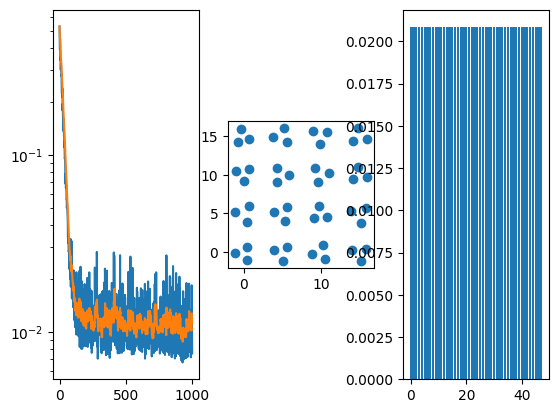

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.9, beta_2=0.999)# future suggestion :  use lr_schedule for step decay schedule !

if (optimize_weights):
  loss_quant = lambda: empirical_radon_sobolev_distance_sq(quant,empirical_sampling(),alphas)
else:
  loss_quant = lambda: empirical_radon_sobolev_distance_sq(quant,empirical_sampling())


nr_iter=1000
loss_val=[]
opt_val=[]
alphas_raw_val=[]
alphas_true_val=[]

for sc in tqdm(range(nr_iter)):
  with tf.GradientTape() as tape:
    loss_value = loss_quant()  # Compute the loss
    if (optimize_weights):
      grads = tape.gradient(loss_value, [quant,alphas])  # Compute the gradient of the loss w.r.t. quant
      opt.apply_gradients(zip(grads, [quant,alphas]))  # Apply the gradient to update quant
    else:
      grads = tape.gradient(loss_value, [quant])  # Compute the gradient of the loss w.r.t. quant
      opt.apply_gradients(zip(grads, [quant]))  # Apply the gradient to update quant

  opt_val.append(quant.numpy())
  loss_val.append(loss_quant())

  if (optimize_weights):
    alphas_raw_val.append(alphas.numpy())
    alphas_true_val.append(scipy_softmax(alphas.numpy()))
  else:
    alphas_raw_val.append(np.ones(K)/K)
    alphas_true_val.append(np.ones(K)/K)

print('quant=',quant.numpy(),' step_count=',nr_iter,' alphas=',alphas_true_val[-1])
plt.figure("quantization")
plt.subplot(1,3,1)
plt.semilogy(loss_val)
df = pd.Series(loss_val)
plt.semilogy(np.array(df.ewm(span=10).mean()))
ax2=plt.subplot(1,3,2)
plt.scatter(np.array(opt_val)[-1,0,:],np.array(opt_val)[-1,1,:])
ax2.set_aspect(1.)
plt.subplot(1,3,3)
plt.bar(list(np.arange(alphas_raw_val[-1].shape[0])),alphas_true_val[-1])

## Further plots and outputs

In [19]:
print("final loss value",loss_val[-1:])
print("final compression points",opt_val[-1])

final loss value [<tf.Tensor: shape=(), dtype=float32, numpy=0.007553744>]
final compression points [[10.266014    3.8350472  -1.0922351   4.2725487  14.148408   14.101038
  15.820492    9.241826    3.9314425  13.8740015  -0.775043    9.790255
   0.09619983  8.956504    8.891038   14.76298     0.42681178 10.768842
   0.6318223  -0.2909037  10.768964   15.130164    0.3947951  -0.9597413
   5.2959485   5.909359   15.798097   10.9756      0.46577024  5.073233
  13.9635105  15.982468    4.28933     5.620771   15.905334   14.758268
   5.631772    9.107895    9.588842   -1.169497   10.560021    5.6323767
   0.7088695   9.834191   15.121645    5.228846    0.754655    3.885655  ]
 [ 0.9040521  14.863367   -0.1793916  10.921733    9.389389   14.309119
   0.39532667 10.821688    5.137148    5.282191   14.230493    5.896289
   9.1253     15.59412    -0.28963226 10.939123   -0.98785675  4.507971
   5.9153156  15.961556   15.526151   -1.1884243   3.896431   10.433702
   4.0467906   9.977365    5.65

<BarContainer object of 48 artists>

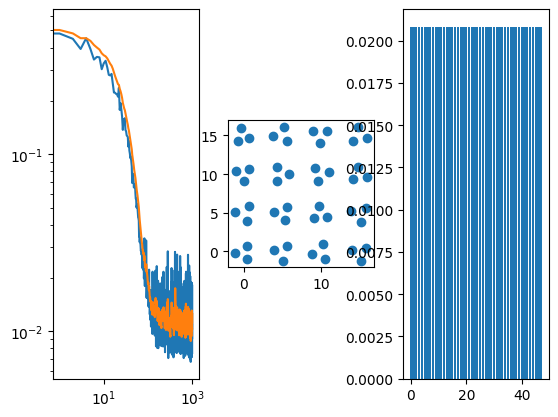

In [20]:
plt.figure(1)
plt.subplot(1,3,1)
plt.loglog(loss_val)
df = pd.Series(loss_val)
plt.loglog(np.array(df.ewm(span=10).mean()))
ax2=plt.subplot(1,3,2)
plt.scatter(np.array(opt_val)[-1,0,:],np.array(opt_val)[-1,1,:])
ax2.set_aspect(1.)
plt.subplot(1,3,3)
plt.bar(list(np.arange(alphas_raw_val[-1].shape[0])),alphas_true_val[-1])


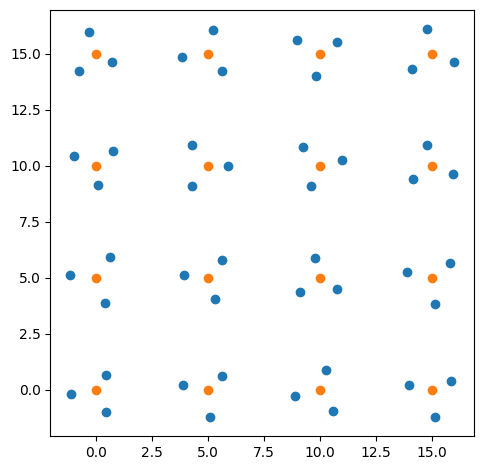

In [21]:
#only plot the middle one
plt.figure(2)
ax2=plt.subplot(1,1,1)
plt.scatter(np.array(opt_val)[-1,0,:],np.array(opt_val)[-1,1,:])
plt.scatter(centers[:,0],centers[:,1])
ax2.set_aspect(1.)
plt.tight_layout()
plt.savefig('16_Gaussians_K'+str(K)+'.pdf')